In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import pandas as pd
import os

In [15]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

#Load ImageNet pre-trained ViT
model_name = 'google/vit-base-patch16-224-in21k' #Model version

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = 4,
    problem_type="multi_label_classification"
) 

# Feature extractor for preprocessing images
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [22]:
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image

class ViTDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)  # Load image and label
        image = feature_extractor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # Apply feature extractor
        return image, label


# DATASET.

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [13]:
#Read dataset.
data_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID"

# List files inside the original dataset
files = os.listdir(data_path)
print("Files in dataset:", files)


Files in dataset: ['images', 'masks']


In [2]:
import shutil
import random
from pathlib import Path

# Define the dataset paths
DATASET_PATH = "//kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
OUTPUT_DIR = "/kaggle/working/covid_split"

TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
VAL_DIR = os.path.join(OUTPUT_DIR, "val")
TEST_DIR = os.path.join(OUTPUT_DIR, "test")

# Define class names (each folder contains "images" and "mask" subfolders)
CLASSES = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# Function to create directories
def create_dirs():
    for split in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        for cls in CLASSES:
            os.makedirs(os.path.join(split, cls), exist_ok=True)

create_dirs()

# Function to split and copy images
def split_data(source_folder, class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    image_folder = os.path.join(source_folder, "images")  # Target "images" subfolder
    image_files = list(Path(image_folder).glob("*.png"))  # Get all image files
    
    random.shuffle(image_files)  # Shuffle for randomness
    
    train_count = int(len(image_files) * train_ratio)
    val_count = int(len(image_files) * val_ratio)
    
    train_files = image_files[:train_count]
    val_files = image_files[train_count:train_count + val_count]
    test_files = image_files[train_count + val_count:]

    # Copy images to train, val, and test folders
    for file in train_files:
        shutil.copy(file, os.path.join(TRAIN_DIR, class_name, file.name))
    
    for file in val_files:
        shutil.copy(file, os.path.join(VAL_DIR, class_name, file.name))
    
    for file in test_files:
        shutil.copy(file, os.path.join(TEST_DIR, class_name, file.name))

# Process each class folder
for cls in CLASSES:
    source_path = os.path.join(DATASET_PATH, cls)  # Main folder for each class
    split_data(source_path, cls)

# Verify the split
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        path = os.path.join(OUTPUT_DIR, split, cls)
        print(f"{split}/{cls}: {len(os.listdir(path))} images")


train/COVID: 2531 images
train/Lung_Opacity: 4208 images
train/Normal: 7134 images
train/Viral Pneumonia: 941 images
val/COVID: 542 images
val/Lung_Opacity: 901 images
val/Normal: 1528 images
val/Viral Pneumonia: 201 images
test/COVID: 543 images
test/Lung_Opacity: 903 images
test/Normal: 1530 images
test/Viral Pneumonia: 203 images


Image 1 | Class: Lung_Opacity | Shape: (299, 299, 3)
Image 2 | Class: Lung_Opacity | Shape: (299, 299, 3)
Image 3 | Class: Normal | Shape: (299, 299, 3)
Image 4 | Class: COVID | Shape: (299, 299, 3)
Image 5 | Class: Viral Pneumonia | Shape: (299, 299, 3)


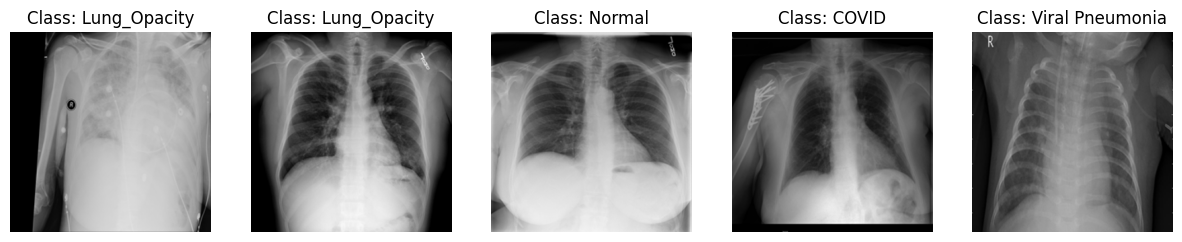

In [28]:
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob

# Define dataset path (update with 'train', 'val', or 'test')
dataset_path = "/kaggle/working/covid_split/train"  # Change to 'val' or 'test' if needed

# Get all image file paths from subdirectories
image_files = glob(os.path.join(dataset_path, "*/*.png"))  # Adjust extension if needed

# Randomly select 5 images
num_images = 5
selected_images = random.sample(image_files, num_images)  # Random sampling

# Create plot
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, img_path in enumerate(selected_images):
    img = cv2.imread(img_path)  # Read as grayscale
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract class from folder name

    print(f"Image {i+1} | Class: {class_name} | Shape: {img.shape}")  # Print class & shape

    # Show image
    axes[i].imshow(img, cmap="gray")  # Use 'gray' colormap for grayscale images
    axes[i].set_title(f"Class: {class_name}")  # Show class as title
    axes[i].axis("off")

plt.show()



In [23]:
# Define dataset paths
train_dir = "/kaggle/working/covid_split/train"
val_dir = "/kaggle/working/covid_split/val"
test_dir = "/kaggle/working/covid_split/test"

# Load datasets
train_dataset = ViTDataset(root=train_dir)
val_dataset = ViTDataset(root=val_dir)
test_dataset = ViTDataset(root=test_dir)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check batch shape
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")


Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([0, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 3, 0, 1, 2, 1, 2, 2, 1,
        3, 0, 2, 2, 1, 1, 2, 1])


# TRAIN.

In [ ]:
#Loss recording and plotting.
#ReciproCAM.
#Model saving.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()  # for multi-label classification

epochs = 1  # adjust as needed

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=inputs)
        logits = outputs.logits

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")


NameError: name 'dataloader' is not defined